In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import minimize
plt.style.use('../notebooks/style.mpl')

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Respiratory heterotrophy model

In [148]:
eps = 1e-10
tau = 1e0
S2 = 2.

In [149]:
def growth_rate_obj(phi_values):
    phi_cat, phi_resp, phi_ana, phi_h = phi_values

    # Objective function for optimization
    # Maximizing nu_ana is equivalent to minimizing -nu_ana
    obj = -phi_ana * gamma_ana_inv

    return obj

### Parameters

In [150]:
# gamma inverses are in /hr units.
gamma_cat_inv = 0.5
gamma_resp_inv = 0.2
gamma_ana_inv = 0.5
gamma_hom_inv = 0.5

phi_cat = 0.3
phi_ana = 0.2
phi_resp = 0.1
phi_h = 0.1
phi_o = 1 - (phi_cat + phi_ana + phi_resp + phi_h)

# maintenance energy
maint = 0.01

# Default params: reliance on respiration.
S4 = 1.0    # ATP yield of respiration
S3 = 0.5    # ATP yield of catabolism
S5 = 0.3    # ATP cost of anabolism
S6 = 0.1    # reduction coefficient of biomass

### Initial conditions

In [151]:
# concentrations in KM units
Corg0 = 1e2
NADH0 = 1e-1
O20 = 1e1
ATP0 = 1e-1

# KM is in uM
KM = 100
r1 = 10.
r2 = 0.1

In [152]:
NADH = NADH0
ATP = ATP0

In [153]:
S6 = -2

In [154]:
# Set the value of phi_o
phi_o = 0.2
maint = 0.00

# Initial guess for the phi variables and metabolite concentrations
initial_values = [0.1, 0.1, 0.1, 0.1, 1e0, 1e0]  # Update as necessary. The last two are ATP and NADH

# Bounds for the phi variables and metabolite concentrations (assuming phi's are between 0 and 1, and metabolite concentrations are positive)
bounds = [(0.00, 1), (0.00, 1), (0.00, 1), (0.00, 1), (1e0, 1e8), (1e0, 1e8)]  # Update as necessary

# Constraint function for the sum of phi parameters and the dNADH and dATP = 0 conditions
cons = ({'type': 'eq', 'fun': lambda x:  sum(x[:-2]) - (1 - phi_o)},  # The sum of the phi's (excluding ATP and NADH) should be 1 - phi_o
        {'type': 'eq', 'fun': lambda x:  S2 * x[0] * gamma_cat_inv * tau - 2 * x[1] * gamma_resp_inv * tau - S6 * x[2] * gamma_ana_inv * tau - x[2] * gamma_ana_inv * tau * x[5]},  # dNADH = 0
        {'type': 'eq', 'fun': lambda x:  S3 * x[0] * gamma_cat_inv * tau + S4 * x[1] * gamma_resp_inv * tau - S5 * x[2] * gamma_ana_inv * tau - x[3] * gamma_hom_inv * tau - maint - x[2] * gamma_ana_inv * tau * x[4]})  # dATP = 0

# Objective function
def growth_rate_obj(values):
    phi_cat, phi_resp, phi_ana, phi_h, ATP, NADH = values

    # Objective function for optimization
    # Maximizing nu_ana is equivalent to minimizing -nu_ana
    obj = -phi_ana * gamma_ana_inv

    return obj

# Call the optimizer
res = minimize(growth_rate_obj, initial_values, method='SLSQP', bounds=bounds, constraints=cons)

# Extract the optimal phi values and metabolite concentrations
phi_cat_opt, phi_resp_opt, phi_ana_opt, phi_h_opt, ATP_opt, NADH_opt = res.x

print('Chosen phi_o:', phi_o)
print('Optimal phi_cat:', phi_cat_opt)
print('Optimal phi_resp:', phi_resp_opt)
print('Optimal phi_ana:', phi_ana_opt)
print('Optimal phi_h:', phi_h_opt)
print('Optimal ATP:', ATP_opt)
print('Optimal NADH:', NADH_opt)


Chosen phi_o: 0.2
Optimal phi_cat: 0.5777777777777785
Optimal phi_resp: 0.0
Optimal phi_ana: 0.22222222222222232
Optimal phi_h: 0.0
Optimal ATP: 1.0000000000000002
Optimal NADH: 7.2000000000268525


Checking if all constraints are satisfied

In [155]:
print('Allocation constraint satisfied:', np.isclose(cons[0]['fun'](res.x), 0, atol=1e-6))
print('NADH balanced:', np.isclose(cons[1]['fun'](res.x), 0, atol=1e-6))
print('ATP balanced:', np.isclose(cons[2]['fun'](res.x), 0, atol=1e-6))

Allocation constraint satisfied: True
NADH balanced: True
ATP balanced: True


In [156]:
-res.fun

0.11111111111111116

# Varying $S_6$

In [223]:
# gamma inverses are in /hr units.
gamma_cat_inv = 0.5
gamma_resp_inv = 2.0
gamma_ana_inv = 0.5
gamma_hom_inv = 0.5

# Set the value of phi_o and maintenance
phi_o = 0.2
maint = 0.000

# Lists to store results
opt_phi_cats = []
opt_phi_resps = []
opt_phi_anas = []
opt_phi_hs = []
fun_mins = []
S6_values = np.linspace(-30, 5, 20)

for S6 in S6_values:
    # Initial guess for the phi variables and metabolite concentrations
    initial_values = [0.1, 0.1, 0.1, 0.1, 1e1, 1e1]  # Update as necessary. The last two are ATP and NADH

    # Bounds for the phi variables and metabolite concentrations (assuming phi's are between 0 and 1, and metabolite concentrations are positive)
    bounds = [(0.00, 1), (0.00, 1), (0.00, 1), (0.00, 1), (5e0, 1e1), (5e0, 1e1)]  # Update as necessary

    # Constraint function for the sum of phi parameters and the dNADH and dATP = 0 conditions
    cons = ({'type': 'eq', 'fun': lambda x:  sum(x[:-2]) - (1 - phi_o)},  # The sum of the phi's (excluding ATP and NADH) should be 1 - phi_o
            {'type': 'eq', 'fun': lambda x:  S2 * x[0] * gamma_cat_inv * tau - 2 * x[1] * gamma_resp_inv * tau - S6 * x[2] * gamma_ana_inv * tau - x[2] * gamma_ana_inv * tau * x[5]},  # dNADH = 0
            {'type': 'eq', 'fun': lambda x:  S3 * x[0] * gamma_cat_inv * tau + S4 * x[1] * gamma_resp_inv * tau - S5 * x[2] * gamma_ana_inv * tau - x[3] * gamma_hom_inv * tau - maint - x[2] * gamma_ana_inv * tau * x[4]})  # dATP = 0

    # Objective function
    def growth_rate_obj(values):
        phi_cat, phi_resp, phi_ana, phi_h, ATP, NADH = values

        # Objective function for optimization
        # Maximizing nu_ana is equivalent to minimizing -nu_ana
        obj = -phi_ana * gamma_ana_inv

        return obj

    # Call the optimizer
    res = minimize(growth_rate_obj, initial_values, method='SLSQP', bounds=bounds, constraints=cons)

    # Extract the optimal phi values and metabolite concentrations
    phi_cat_opt, phi_resp_opt, phi_ana_opt, phi_h_opt, ATP_opt, NADH_opt = res.x
    
    # Saving the optimal values.
    opt_phi_cats.append(phi_cat_opt)
    opt_phi_resps.append(phi_resp_opt)
    opt_phi_anas.append(phi_ana_opt)
    opt_phi_hs.append(phi_h_opt)
    fun_mins.append(-res.fun)

# Combine results into a DataFrame
df = pd.DataFrame({
    's6s': S6_values,
    'opt_phi_cat': opt_phi_cats,
    'opt_phi_resp': opt_phi_resps,
    'opt_phi_ana': opt_phi_anas,
    'opt_phi_h': opt_phi_hs,
    'lambda': fun_mins,
})

In [224]:
df

,s6s,opt_phi_cat,opt_phi_resp,opt_phi_ana,opt_phi_h,lambda
0,-30.000000,5.249496e-16,0.571429,0.228571,3.768735e-16,0.114286
1,-28.157895,1.253727e-15,0.555332,0.244668,5.197390e-16,0.122334
2,-26.315789,0.000000e+00,0.536797,0.263203,0.000000e+00,0.131602
3,-24.473684,4.335453e-17,0.515222,0.284778,0.000000e+00,0.142389
4,-22.631579,3.338470e-16,0.489796,0.310204,0.000000e+00,0.155102
5,-20.789474,2.021092e-15,0.459384,0.340616,6.523136e-16,0.170308
6,-18.947368,0.000000e+00,0.455914,0.344086,2.141012e-16,0.172043
7,-17.105263,2.260182e-15,0.455914,0.344086,0.000000e+00,0.172043
8,-15.263158,3.706787e-02,0.432796,0.330136,8.760354e-17,0.165068
9,-13.421053,1.962667e-01,0.333511,0.270222,2.515349e-16,0.135111


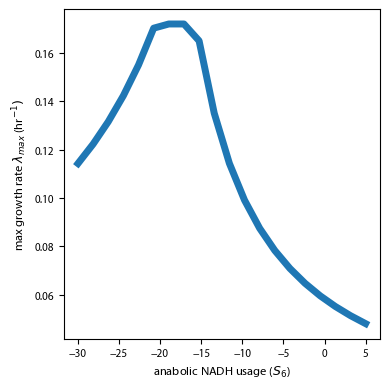

In [225]:
fig, ax = plt.subplots( 1, 1, figsize=(4, 4) )

ax.set_ylabel( 'max growth rate ' + r'$\lambda_{max}$' + ' (hr' + r'$^{-1})$' )
ax.set_xlabel( 'anabolic NADH usage (' + r'$S_6$)')
ax.plot( df['s6s'], df['lambda'], lw=5 )

fig.tight_layout()
plt.show()